## Analyze AB Test Result
- For this project, I've analyzed a test result ran by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. Your goal is to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

In [1]:
# import tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(42)

In [2]:
# import data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### Part I - Probability

- Number of rows

In [3]:
df.shape[0]

294478

- Number of unique users in the dataset

In [4]:
df.user_id.nunique()

290584

- The proportion of users converted

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df_treat_nomatch = df[(df.group == 'treatment') & (df.landing_page != 'new_page')]
df_contr_nomatch = df[(df.group == 'control') & (df.landing_page != 'old_page')]

# create dataframe and index incase of dropping later
df_nomatch = pd.concat([df_treat_nomatch, df_contr_nomatch])
df_nomatch_index = df_nomatch.index

# grab lengh of the no match list
len(df_nomatch)

3893

- Do any of the rows have missing values?

In [7]:
df.isnull().any().sum()

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# drop no match values list for inaccuracy and create new dataframe
df2 = df.drop(df_nomatch_index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

There is one **user_id** repeated in **df2**.

In [11]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [12]:
# drop duplicates
df2.drop_duplicates(inplace=True)

What is the probability of an individual converting regardless of the page they receive?

In [13]:
df2.converted.mean()

0.11959667567149027

Given that an individual was in the `control` group, what is the probability they converted?

In [14]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [15]:
df2.query('group == "treatment"')['converted'].mean()

0.11880724790277405

What is the probability that an individual received the new page?

In [16]:
df.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5066985563604454

Is there evidence that one page leads to more convertions?
__Yes, data shows that receiving old page leads to more convertions.__

### Part II - A/B Test

I'll assume the old page is better unless the new page proves to be definately better than Type I error rate of 5%.
I'll state my null and alternative hypothesis as **$P_{old}$** and **$P_{new}$**

$$H_0: P_{new} - P_{old} \leq 0$$
$$H_1: P_{new} - P_{old} > 0$$

a. What is the **convert rate** for $p_{new}$ under the null? 

In [17]:
p_new = df2.query('group == "treatment"')['converted'].mean()
p_new

0.11880724790277405

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [18]:
p_old = df2.query('group == "control"')['converted'].mean()
p_old

0.1203863045004612

In [19]:
# probability of conversion
p_mean = np.mean([p_new, p_old])
p_mean

0.11959677620161763

In [20]:
# then get difference between p_new and p_old
p_diff = p_new - p_old
p_diff

-0.0015790565976871451

c. What is $n_{new}$?

In [21]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145311

d. What is $n_{old}$?

In [22]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
# use numpy random choice for simulation of convert rate
new_page_converted = np.random.choice(a=[0,1], size=n_new, p=[(1-p_mean), p_mean])
np.mean(new_page_converted)

0.12031436023425618

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice(a=[0,1], size=n_old, p=[(1-p_mean), p_mean])
np.mean(old_page_converted)

0.11964288172694357

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
np.mean(new_page_converted) - np.mean(old_page_converted)

0.0006714785073126117

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [26]:
diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice(a=[0,1], size=n_new, p=[(1-p_mean), p_mean])
    old_page_converted = np.random.choice(a=[0,1], size=n_old, p=[(1-p_mean), p_mean])
    diff = np.mean(new_page_converted) - np.mean(old_page_converted)
    diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

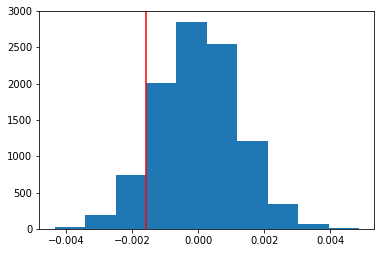

In [27]:
plt.hist(diffs)
plt.axvline(p_new-p_old, color='r');

# the distribution is normal as expected. The mean is pretty much zero.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
# about 90 percent of all p_diffs are greater than observed diffs
greater_than_diff = [_ for _ in diffs if _ > p_diff]
p_greater_diff = len(greater_than_diff) / len(diffs)
p_greater_diff

0.9043

**Result:** The result of the p-value indicates that 90 percent of the population in the simulated sample are above the real difference which means that we failed to reject the null hypothesis. So new page should not be implemented.

I can also use built-in function to achieve similar result. It's easier to code but not as walkthrough and easily understandable.

In [30]:
# import statmodel
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
n_old = n_old
n_new = n_new

In [31]:
print("convert_old: {}".format(convert_old))
print("convert_new: {}".format(convert_new))
print("n_old: {}".format(n_old))
print("n_new: {}".format(n_new))

convert_old: 17489
convert_new: 17264
n_old: 145274
n_new: 145311


In [32]:
# calculate z_score and p_value
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old])
print("z_score: {}".format(z_score))
print("p_value: {}".format(p_value))

z_score: -1.3116075339133115
p_value: 0.18965258971881804


**Result:** The zscore is the number of standard deviations from the mean a data point is. So with that, the differences between the lines in the histrogram is above -1.31 std. Again, a p_value of 19 percent means we fail to reject null hypothesis._